# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def explore_data(data):
    '''Знакомство с данными'''
    display(data)
    data.info()
    data.describe()
    print()
    print('Количество дубликатов:', data.duplicated().sum(), sep='\n',end='\n\n')
    print('Количество пропусков:', data.isna().sum(), sep='\n', end='\n\n')
    print('Распределение значений в данных:')
    display(data.describe())
    

## Откройте и изучите файл

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

Изучим данные с помощью созданной функции **explore_data**

In [4]:
explore_data(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0
...,...,...,...,...,...
3209,122.00,910.98,20.00,35124.90,1
3210,25.00,190.36,0.00,3275.61,0
3211,97.00,634.44,70.00,13974.06,0
3212,64.00,462.32,90.00,31239.78,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB

Количество дубликатов:
0

Количество пропусков:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

Распределение значений в данных:


,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


Контрольно проверим уникальные значения в is_ultra, и распределения данных между ними.

In [5]:
df['is_ultra'].unique()

array([0, 1])

In [6]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Проверю, есть ли данные которые сильно зависят друг от друга.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f628d302350>,
      dtype=object)

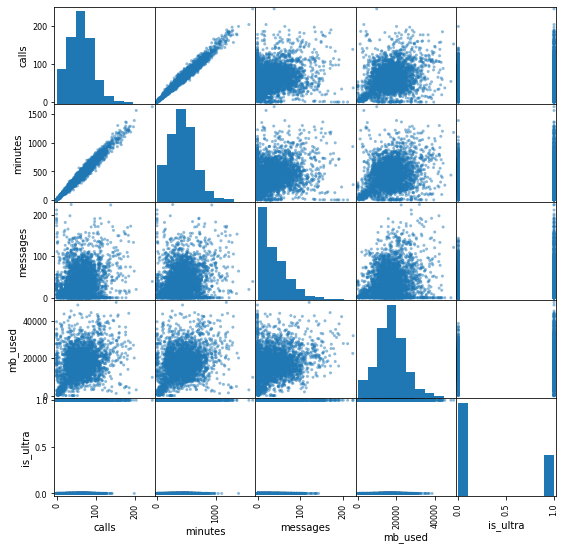

In [7]:
pd.plotting.scatter_matrix(df, figsize=(9, 9))

По матрице диаграммы рассеивания видно что зависимость наблюдается между количеством звонков и минутами. Проверю коэфицент кореляции.

In [8]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.18,0.29,0.21
minutes,0.98,1.00,0.17,0.28,0.21
messages,0.18,0.17,1.00,0.20,0.20
mb_used,0.29,0.28,0.20,1.00,0.20
is_ultra,0.21,0.21,0.20,0.20,1.00


Коэфцент кореляции между данными в calls и в minutes равен 0.98 - наблюдается сильная зависимость. Можно исключить один из данных столбцов. 

**Вывод**

Изучив данные можно сказать что:
1. В данных отсустсвуют пропуски
2. В данных отсутсвуют дубликаты
3. Типы данных подходят для дальнейшей работы, хотя можно поменять тип данных в calls и messages на int64
4. Количество данных со значением "0" в is_ultra значительно больше значения "0"
5. Коэфцент кореляции между данными в calls и в minutes равен 0.98 - наблюдается сильная зависимость. Можно исключить один из данных столбцов.

## Разбейте данные на выборки

Для обучения и проверки модели необходимо выполнить следующие шаги:
1. Извлечь признаки
2. Извлечь целевой признак
3. Разбить данные на три части: обучающую, тестовую и валидационную.

Исключаем офактор calls, так как он имеет сильную взаимосвязь с фактором minutes.

In [9]:
df = df.drop(['calls'], axis=1)

**Извлекаем признаки**

In [10]:
features = df.drop(['is_ultra'], axis=1)

**Извлекаем целевой признак**

In [11]:
targets = df['is_ultra']

**Разбиваю данные на обучающие, тестовые и валидационные**

Разбивать данные буду в следующих пропорциях: обучающие - 60%, тестовые - 20%, валидационные - 20%

Изначально раделим данные на две части в пропорции обучающие - 60%, проверочные - 40%. Для стратификации целевого признака задаем параметр **stratify = targets**.

In [12]:
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.4, random_state=123, stratify=targets)

Разобьем проверочные данные на две одинакоые части: тестовую и валидационную.

In [13]:
features_valid, features_test, targets_valid, targets_test = train_test_split(
    features_test, targets_test, test_size=0.5, random_state=123, stratify=targets_test)

In [14]:
print(f"Количество строк в обучающих данных по целевому признаку: {np.bincount(targets_train)}")
print(f"Количество строк в валидационных данных по целевому признаку: {np.bincount(targets_valid)}")
print(f"Количество строк в тестовых данных по целевому признаку: {np.bincount(targets_test)}")

Количество строк в обучающих данных по целевому признаку: [1337  591]
Количество строк в валидационных данных по целевому признаку: [446 197]
Количество строк в тестовых данных по целевому признаку: [446 197]


**Вывод**

На данном этапе я провел разбивку данных на три группы: обучающую, тестовую и валидационную. При делении на группы я обеспечил равномерное распределение целевого признака между группами. 

## Исследуйте модели

На данном этапе проведу обучениеи и выберу лучшую модель по метрике качества в зависимости от гиперпараметров (где возможно) следующих моделей:
1. Решающее дерево
2. Случайны лес
3. Логистическая регрессия
4. Метод опорных векторов
5. Метод ближайших соседей

Создам списки из лучших моделей, их названия и качества на валидационной выборке.

In [15]:
model_name = []
model_list = []
best_accuracy_valid_list = []

### Решающее дерево

Обучю модель решающего дерева с максимальной глубиной от 1 до 10 и выберу модель с лучшим показателем качества по валидационной выборке.

In [16]:
best_model_dtc = None
best_accuracy_dtc = 0
best_depth = 0
for i in range(1,11):
    model = DecisionTreeClassifier(random_state=123, max_depth = i)
    model.fit(features_train, targets_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(targets_valid, predictions_valid)
    if accuracy > best_accuracy_dtc:
        best_depth = i
        best_accuracy_dtc = accuracy
        best_model_dtc = model
        
model_name.append('Решающее дерево')
model_list.append(best_model_dtc)
best_accuracy_valid_list.append(best_accuracy_dtc)

print(f"Лучший показатель accuracy модели решающего дерева по валидационной выборке равен \
{'{:.3f}'.format(best_accuracy_dtc)} с глубиной {best_depth}")

Лучший показатель accuracy модели решающего дерева по валидационной выборке равен 0.795 с глубиной 3


### Случайный лес

Обучю модель случайного леса с количеством деревьев от 1 до 50, с максимальной глубиной от 1 до 10 и выберу модель с лучшим показателем качества по валидационной выборке.

In [17]:
best_model_rfr = None
best_accuracy_rfr = 0
best_est = 0
best_depth = 0
for est in range(1, 51):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=123, n_estimators=est, max_depth=depth)
        model.fit(features_train, targets_train)
        predictions_valid = model.predict(features_valid)
        accuracy = accuracy_score(targets_valid, predictions_valid)
        if accuracy > best_accuracy_rfr:
            best_model_rfr = model
            best_accuracy_rfr = accuracy
            best_est = est
            best_depth = depth
            
model_name.append('Случайный лес')
model_list.append(best_model_rfr)
best_accuracy_valid_list.append(best_accuracy_rfr)

print(f"Лучший показатель accuracy модели случайного леса по валидационной выборке равен \
{'{:.3f}'.format(best_accuracy_rfr)}, количество деревьев {best_est} с глубиной {best_depth}")

Лучший показатель accuracy модели случайного леса по валидационной выборке равен 0.804, количество деревьев 15 с глубиной 9


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
<font color='green'><br>ок

### Логистическая регрессия

Обучу модель логистической регрессии и проверю ее качество на валидационной выборке.

In [18]:
model_lr = LogisticRegression(random_state=123)
model_lr.fit(features_train, targets_train)
accuracy_lr = model.score(features_valid, targets_valid)

model_name.append('Логистическая регрессия')
model_list.append(model_lr)
best_accuracy_valid_list.append(accuracy_lr)

print(f"Показатель accuracy модели логистической регрессии по валидационной выборке равен \
{'{:.3f}'.format(accuracy_lr)}")

Показатель accuracy модели логистической регрессии по валидационной выборке равен 0.793


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Метод опорных векторов

Обучу модель метода опорных векторов и проверю ее качество на валидационной выборке.

In [19]:
model_svc = SVC(random_state=123)
model_svc.fit(features_train, targets_train)
accuracy_svc = model.score(features_valid, targets_valid)

model_name.append('Метод опорных векторов')
model_list.append(model_svc)
best_accuracy_valid_list.append(accuracy_svc)

print(f"Показатель accuracy модели метода опорных векторов по валидационной выборке равен \
{'{:.3f}'.format(accuracy_svc)}")

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Показатель accuracy модели метода опорных векторов по валидационной выборке равен 0.793


### Метод ближайших соседей

Обучю модель методф ближайших соседей с количеством соседей от 5 до 30 и выберу модель с лучшим показателем качества по валидационной выборке.

In [20]:
best_model_knc = None
best_accuracy_knc = 0
best_neighbors = 0
for i in range(5,31):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(features_train, targets_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(targets_valid, predictions_valid)
    if accuracy > best_accuracy_knc:
        best_neighbors = i
        best_accuracy_knc = accuracy
        best_model_knc = model
        
model_name.append('Метод ближайших соседей')
model_list.append(best_model_knc)
best_accuracy_valid_list.append(best_accuracy_knc)

print(f"Лучший показатель accuracy модели метода ближайших соседей по валидационной выборке равен \
{'{:.3f}'.format(best_accuracy_knc)} с количесвом соседей {best_neighbors}")

Лучший показатель accuracy модели метода ближайших соседей по валидационной выборке равен 0.781 с количесвом соседей 9


### Вывод

На данном этапе я обучил 5 моделей по обучающий выборке и проверил их качество на валидационной выборке и поличил следкющие результаты:
1. **Решающее дерево** - Лучший показатель accuracy модели решающего дерева по валидационной выборке равен **0.795** с глубиной 3
2. **Случайны лес** - Лучший показатель accuracy модели случайного леса по валидационной выборке равен **0.804**, количество деревьев 15 с глубиной 9
3. **Логистическая регрессия** - Показатель accuracy модели логистической регрессии по валидационной выборке равен **0.793**
4. **Метод опорных векторов** - Показатель accuracy модели метода опорных векторов по валидационной выборке равен **0.793**
5. **Метод ближайших соседей** - Лучший показатель accuracy модели метода ближайших соседей по валидационной выборке равен **0.781** с количесвом соседей 9

На валидационной выборке модель случайного леса показала себя наилучшим образм.Следующая по качеству идет модель решающего дерева. Модели, логистической регресии и метода опорных векторов показали себя немного хуже и имеют одинаковый между собой показатель качества, возможно из-за линейного принципа предсказания. Метод ближайших соседей показал самое низкое значение качества.


## Проверьте модель на тестовой выборке

Во время обучения моделей я записывал лучшие модели в отдельные списки, теперь проверим как показывают себя данные модели на тестовой выборке.

In [21]:
best_model = None
best_model_name = None
best_model_accuracy = 0
for i in range(len(model_list)):
    model = model_list[i]
    predictions_valid = model.predict(features_test)
    accuracy = accuracy_score(targets_test, predictions_valid)
    print(f"Accuracy модели {model_name[i]} на валидационной выборке: {'{:.3f}'.format(best_accuracy_valid_list[i])}; на тестовой: {'{:.3f}'.format(accuracy)}")
    if accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = model
        best_model_name = model_name[i]

print(f"\nЛучшее accuracy на тестовой выборке у модели {best_model_name}, значение параметра качества {'{:.3f}'.format(best_model_accuracy)}")

Accuracy модели Решающее дерево на валидационной выборке: 0.795; на тестовой: 0.802
Accuracy модели Случайный лес на валидационной выборке: 0.804; на тестовой: 0.820
Accuracy модели Логистическая регрессия на валидационной выборке: 0.793; на тестовой: 0.708
Accuracy модели Метод опорных векторов на валидационной выборке: 0.793; на тестовой: 0.694
Accuracy модели Метод ближайших соседей на валидационной выборке: 0.781; на тестовой: 0.784

Лучшее accuracy на тестовой выборке у модели Случайный лес, значение параметра качества 0.820


**Вывод**

Проверив обученные модели на тестовой выборке наилучший результат по значению accuracy показал модель случайного леса с количеством деревьев равным 15, и глубиной 9.

## Вывод

В данном проекте:
1. Я изучил предоставленные данные, они были полность готовы к работе и не требовали предобработки.
2. Были выделены признаки и целевой признак
3. Разделил данные на три групы обучающие, валидационные и тестовые с соотношением 60-20-20.
4. Обучил 5 моделей предсказания по следующими методами: решающее дерево, сучайны лес, логистическая регрессия, метод опорных векторов, метод ближайших соседей. Проверил их качество на валидационной выборке и получил наилучшие значение accuracy у двух моделей решающего дерева и случайного леса.
5. Проверил все модели на тестовой выборке и получил модель с наилучшим показателем accuracy по тестовой выборке.

**По результатам данного иследования, для подбора подходящего тарифа предлагаю использовать модель обученную методом случайного леса, с количеством деревьев 15 и глубиной 9, показатель accuracy у данной модели 0.82**